# 1. Preparing Tool Box

In [2]:
import os
for dirname, _, filenames in os.walk('\pkbhx\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

\pkbhx\data\pkbhx.csv


Import the necessary Python libraries

In [115]:
# from math import sqrt
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.linear_model import RidgeCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from tpot import TPOTRegressor
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from yellowbrick.regressor import PredictionError, ResidualsPlot

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# 2. Reading the Data

Read the comma-separated values (csv) file and put the data into a Pandas Dataframe

In [4]:
# Create a DataFrame
data = pd.read_csv('\pkbhx\data\pkbhx.csv', sep=';')

# 3. Data Cleaning and Pre-processing

In [6]:
# Is there any null values?
print(data.isnull().values.any())

False


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  993 non-null    object 
 1   pK_BHX  993 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.6+ KB


In [5]:
# There might be one or more valid SMILES that can represent one compound
# Generate Canonical SMILES
def canonical_smiles(smiles):
    mols = [Chem.MolFromSmiles(smi) for smi in smiles]
    smiles = [Chem.MolToSmiles(mol) for mol in mols]
    return smiles

In [6]:
Canon_SMILES = canonical_smiles(data.SMILES)

# Put the smiles in the dataframe
data['SMILES'] = Canon_SMILES

In [10]:
# Analyzing the duplicates
print(f'{data.duplicated().sum()} duplicated records in {len(data)} total records.\n',
      f'Resulting in {data.duplicated().sum()/len(data)*100:.1f}% of duplicated records.')

0 duplicated records in 993 total records.
 Resulting in 0.0% of duplicated records.


In [7]:
# The RDKit package calculates the molecular descriptors like
# molecular weight, the number of valence electrons, and the maximum
# and minimum partial charge for all molecules using as input the
# SMILE representation.
calc = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
rdkit_2d_desc = []
for k in range(len(data)):
  header = calc.GetDescriptorNames()
  d = calc.CalcDescriptors(Chem.MolFromSmiles(data.iloc[k, 0]))
  rdkit_2d_desc.append(d)

temp_df = pd.DataFrame(rdkit_2d_desc, columns=header)  

data = pd.concat([data, temp_df], axis=1)

In [8]:
# Is there any null values?
print(data.isnull().values.any())

True


In [30]:
data[data.isnull().any(axis=1)]

,SMILES,pK_BHX,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
697,c1ccc(C[Se](Cc2ccccc2)=[O:1])cc1,3.30,11.990193,-1.770000,11.990193,0.731879,0.785197,277.225,263.113,278.020986,...,0,0,0,0,0,0,0,0,0,0
698,C[Se](C)=[O:1],3.43,9.652778,-1.291667,9.652778,1.291667,0.434580,125.029,118.981,125.958386,...,0,0,0,0,0,0,0,0,0,0
839,c1ccc(P(c2ccccc2)(c2ccccc2)=[Se:1])cc1,0.94,3.550556,-1.651435,3.550556,1.372593,0.507427,341.252,326.132,342.007658,...,0,0,0,0,0,0,0,0,0,0
847,c1ccc([As](c2ccccc2)(c2ccccc2)=[O:1])cc1,4.15,13.878819,-3.544896,13.878819,0.933356,0.675029,322.239,307.119,322.033887,...,0,0,0,0,0,0,0,0,0,0
903,C[Se:1]C,-0.01,2.187500,0.875000,2.187500,0.875000,0.403159,109.030,102.982,109.963471,...,0,0,0,0,0,0,0,0,0,0


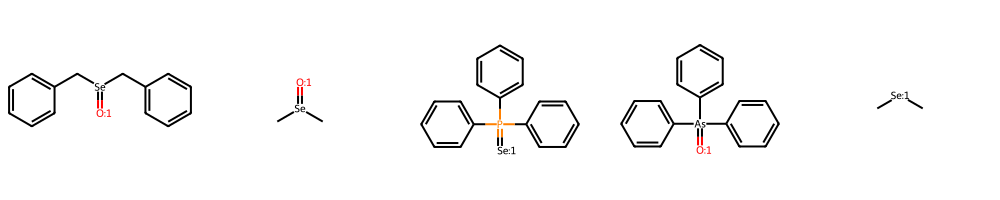

In [31]:
# Let's look at the molecules that generated descriptors with nan values
nan_df = data[data.isnull().any(axis=1)][['SMILES']]
mols = [Chem.MolFromSmiles(smi) for smi in nan_df.SMILES]
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))

In [32]:
# Columns with nan values
na_names = data.isnull().any()
list(na_names.where(na_names == True).dropna().index)

['MaxPartialCharge',
 'MinPartialCharge',
 'MaxAbsPartialCharge',
 'MinAbsPartialCharge',
 'BCUT2D_MWHI',
 'BCUT2D_MWLOW',
 'BCUT2D_CHGHI',
 'BCUT2D_CHGLO',
 'BCUT2D_LOGPHI',
 'BCUT2D_LOGPLOW',
 'BCUT2D_MRHI',
 'BCUT2D_MRLOW']

The RDKit package failed to calculate some descriptors values, so the action taken was to attribute the missing values

In [9]:
header = list(data.columns)

# Imputing missing values with mean column value using SimpleImputer
si = SimpleImputer(missing_values=np.nan, strategy='mean')
si = si.fit(data.drop(columns='SMILES'))

data_si = pd.DataFrame(si.transform(data.drop(columns='SMILES')))
data = pd.concat([data['SMILES'], data_si], axis=1)
data.columns = header

In [34]:
# Is there any null values?
print(data.isnull().values.any())

False


In [10]:
# Drop the column SMILES
data.drop(columns=['SMILES'], inplace=True)

In [8]:
data.shape

(993, 209)

In [37]:
data.head(5)

,pK_BHX,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.90,10.605370,0.058426,10.605370,0.058426,0.523744,121.139,114.083,121.052764,46.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.78,5.006944,0.888889,5.006944,0.888889,0.434057,87.122,78.050,87.068414,36.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.67,3.263889,1.212963,3.263889,1.212963,0.473722,103.190,94.118,103.045570,36.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.10,3.185185,1.166667,3.185185,1.166667,0.457255,89.163,82.107,89.029920,30.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.56,5.098194,0.913194,5.098194,0.913194,0.423889,101.149,90.061,101.084064,42.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
data_y = data['pK_BHX'] # Dataframe with the target
data_X = data.drop(columns=['pK_BHX']) # Dataframe with the features

In [12]:
data_X.shape, data_y.shape

((993, 208), (993,))

Use a variance threshold to remove any feature that has little to no variation in their values

In [13]:
header = list(data_X.columns)

vt = VarianceThreshold()
data_X = vt.fit_transform(data_X)

cols = vt.get_support(indices=True)

selected_features = []
for i in range(len(cols)):
    selected_features.append(header[cols[i]])

data_X = pd.DataFrame(data_X, columns=selected_features)

In [13]:
data_X.shape

(993, 186)

In this step, twenty-two features have been removed.

Now, find and remove features with Pearson correlation equal to or higher than the threshold 

In [14]:
def correlation(dataset, threshold):
    col_corr = set()
    
    corr_matrix = dataset.corr(method="pearson") # Compute pairwise Pearson correlation coefficients
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i][j]) >= threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    
    dataset.drop(col_corr, axis=1, inplace=True)
    
    return dataset

In [15]:
# Remove feature(s) with Pearson correlation equal to or higher than 0.95 
data_X = correlation(data_X, 0.95)

In [15]:
data_X.shape

(993, 156)

Here thirty features have been removed.

In [16]:
# Split Data into Training (80%) and Test set (20%)
X_train, X_test, y_train, y_test = model_selection.train_test_split(data_X, data_y, test_size=0.2, random_state=0)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((794, 156), (199, 156), (794,), (199,))

# 4. Setting Models

Models: 

1. Support Vector Machine (SVR)
2. K-Nearest Neighbors (NN)
3. Light Gradient Boosting (LGB)
4. Random Forest (RF)
5. Tree-based Pipeline Optimization Tool (TPOT)

In [19]:
# Prepare a DataFrame that will store the scoring metrics for each model
metrics = pd.DataFrame(index=['R**2', 'Mean Absolute Error (MAE)', 'Mean Square Error (MSE)', 'Root Mean Square Error (RMSE)'],
                       columns=['Dummy Regressor', 'Support Vector Machine', 'Nearest Neighbors', 'Light Gradient Boosting', 'Random Forest', 'TPOT'])

Apply the GridSearchCV for hyperparameter tuning

In [20]:
def gridsearch_hyper(model_name, estimator, parameter_grid):
  gs = GridSearchCV(estimator, parameter_grid, cv=5, scoring='r2')

  # Fit on Training
  gs.fit(X_train, y_train)
  
  # Predict on Test
  y_pred = gs.predict(X_test)

  # Scoring
  metrics.loc['R**2', model_name] = r2_score(y_test, y_pred)
  metrics.loc['Mean Absolute Error (MAE)', model_name] = mean_absolute_error(y_test, y_pred)
  metrics.loc['Mean Square Error (MSE)', model_name] = mean_squared_error(y_test, y_pred)
  metrics.loc['Root Mean Square Error (RMSE)', model_name] = mean_squared_error(y_test, y_pred, squared=False)

  print(f'Best parameters to {model_name}: {gs.best_params_}')

In [21]:
# Space of hyperparameters and estimators we want to search through
model_name = ['Dummy Regressor', 'Support Vector Machine', 'Nearest Neighbors', 'Light Gradient Boosting', "Random Forest"]

parameter_grid_dr = {
    'estimator__strategy':['mean', 'median']
}

parameter_grid_svr = {
    'estimator__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'estimator__degree':[3, 4, 5],
    'estimator__gamma':['scale', 'auto'],
    'estimator__coef0':[0.1, 0.25, 0.5, 1.0, 3.0, 5.0],
    'estimator__C':[0.01, 0.1, 0.25, 0.5, 1.0, 3.0, 5.0]
}

parameter_grid_nn = {
    'estimator__n_neighbors':[5, 6, 8, 10],
    'estimator__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'estimator__weights':['uniform', 'distance']
}

parameter_grid_lgb = {
    'estimator__learning_rate':[0.001, 0.01, 0.1],
    'estimator__max_depth':[4, 6, 8, 10],
    'estimator__tree_learner':['serial', 'feature', 'data', 'voting']
}

parameter_grid_rf = {
    'estimator__n_estimators':[10, 25, 50, 100],
    'estimator__criterion':['squared_error', 'absolute_error'],
    'estimator__max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'estimator__max_features':['auto', 'sqrt', 'log2']
}

Using a pipeline to chain the preprocessing with the estimator and then execute the hyperparameter tunning using GridSearchCV

Base Model: Dummy Model

In [22]:
model_dr = DummyRegressor()

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_dr)])
gs_dr = gridsearch_hyper('Dummy Regressor', pipe, parameter_grid_dr)

Best parameters to Dummy Regressor: {'estimator__strategy': 'mean'}


1st Model: Support Vector Machine (SVR)

In [24]:
model_svr = SVR()

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_svr)])
gs_svr = gridsearch_hyper('Support Vector Machine', pipe, parameter_grid_svr)

Best parameters to Support Vector Machine: {'estimator__C': 3.0, 'estimator__coef0': 0.1, 'estimator__degree': 3, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf'}


2nd Model: K-Nearest Neighbors (NN)

In [25]:
model_nn = KNeighborsRegressor()

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_nn)])
gs_nn = gridsearch_hyper('Nearest Neighbors', pipe, parameter_grid_nn)

Best parameters to Nearest Neighbors: {'estimator__algorithm': 'ball_tree', 'estimator__n_neighbors': 5, 'estimator__weights': 'distance'}


3rd Model: Light Gradient Boosting (LGB)

In [26]:
model_lgb = lgb.LGBMRegressor(random_state=0, verbosity=-1)

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_lgb)])
gs_lgb = gridsearch_hyper('Light Gradient Boosting', pipe, parameter_grid_lgb)

Best parameters to Light Gradient Boosting: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 10, 'estimator__tree_learner': 'serial'}


4th Model: Random Forest (RF)

In [27]:
model_rf = RandomForestRegressor(random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('estimator', model_rf)])
gs_rf = gridsearch_hyper('Random Forest', pipe, parameter_grid_rf)

Best parameters to Random Forest: {'estimator__criterion': 'squared_error', 'estimator__max_depth': 10, 'estimator__max_features': 'auto', 'estimator__n_estimators': 100}


5th Model: Tree-based Pipeline Optimization Tool ([TPOT](https://link.springer.com/content/pdf/10.1007/s10710-021-09401-z.pdf?pdf=button))

In [ ]:
tpot_regressor = TPOTRegressor(generations=5, population_size=1000, scoring='r2', n_jobs=-1, verbosity=2, random_state=0)
tpot_regressor.fit(X_train.values, y_train)
tpot_regressor.export('/pkbhx/data/tpot_exported_pipeline_g5_p1000.py')

Optimization Progress:   0%|          | 0/6000 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8314090768719643

Generation 2 - Current best internal CV score: 0.8353892974628812

Generation 3 - Current best internal CV score: 0.8353892974628812

Generation 4 - Current best internal CV score: 0.8353892974628812

Generation 5 - Current best internal CV score: 0.8375088518744237

Best pipeline: RidgeCV(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=0.25, min_samples_leaf=1, min_samples_split=9, n_estimators=100))


In [116]:
# Average CV score on the training set was: 0.8375088518744237
exported_pipeline = make_pipeline(
    StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True, max_features=0.25,
                        min_samples_leaf=1, min_samples_split=9, n_estimators=100)),
    RidgeCV()
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 0)

exported_pipeline.fit(X_train.values, y_train)

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=ExtraTreesRegressor(bootstrap=True,
                                                                 max_features=0.25,
                                                                 min_samples_split=9,
                                                                 random_state=0))),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [99]:
y_hat = pd.DataFrame(exported_pipeline.predict(X_test))

In [100]:
metrics.loc['R**2', 'TPOT'] = r2_score(y_test, y_hat)
metrics.loc['Mean Absolute Error (MAE)', 'TPOT'] = mean_absolute_error(y_test, y_hat)
metrics.loc['Mean Square Error (MSE)', 'TPOT'] = mean_squared_error(y_test, y_hat)
metrics.loc['Root Mean Square Error (RMSE)', 'TPOT'] = mean_squared_error(y_test, y_hat, squared=False)

# 5. Evaluating the Models

In [101]:
metrics

,Dummy Regressor,Support Vector Machine,Nearest Neighbors,Light Gradient Boosting,Random Forest,TPOT
R**2,-0.005299,0.76658,0.722685,0.772499,0.770272,0.798835
Mean Absolute Error (MAE),0.732584,0.27298,0.324339,0.276302,0.283361,0.250666
Mean Square Error (MSE),0.850519,0.197481,0.234618,0.192474,0.194358,0.170193
Root Mean Square Error (RMSE),0.922236,0.444389,0.484374,0.438719,0.440861,0.412544


In [72]:
# Confidence Intervals (CI) for R**2
# k is the number of independent variables and n is the number of abservations
# Based in Applied Multiple Regression/Correlation Analysis for the Behavioral Sciences
'''def rsquareCI(r2, n, k):
    se = sqrt((4*(r2**2))*((1-r2)**2)*(n-k-1)**2)/((n**2-1)*(n+3))

    # For CI=95% use the constant multiplier =2
    z = r2+2*se
    delta = z-r2
    return r2, delta'''

In [ ]:
'''list_metrics = []
for i in range(metrics.shape[1]):
    #test_df.append(rsquareCI(metrics.iloc[0, i], X_test.shape[1], X_test.shape[0]))
    list_metrics.append(rsquareCI(metrics.iloc[0, i], X_test.shape[1], X_test.shape[0]))

r2_scorer = pd.DataFrame()
r2_scorer['Metrics'] = list_metrics
r2_scorer = pd.DataFrame(r2_scorer['Metrics'].to_list(), columns = ['R**2', 'deltaR**2'])

r2_scorer.insert(0, 'Model', metrics.columns)

r2_scorer'''

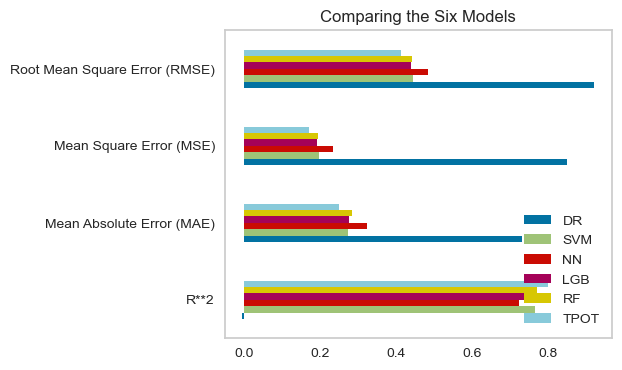

In [118]:
fig, ax = plt.subplots(figsize=(5, 4))
metrics.plot(kind='barh', ax=ax)
ax.grid()
ax.set_title('Comparing the Six Models')
plt.legend(['DR', 'SVM', 'NN', 'LGB', 'RF', 'TPOT'], loc=4, shadow=True)
#plt.annotate('Close to 0 is better', xy=(0.1, 0.58))
#plt.annotate('Close to 1 or -1 is better', xy=(0.1, 0.3))
#plt.axhline(y=0.5, linestyle='--')
plt.show()

The best accuracy was achieved using the model generated by TPOT. 

Using [Yellowbrick](https://www.scikit-yb.org/) to visual analysis of the best ML model

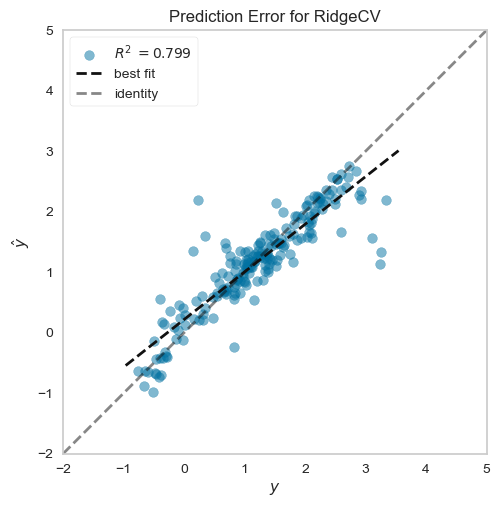

<AxesSubplot:title={'center':'Prediction Error for RidgeCV'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [111]:
# Instantiate the linear model and visualizer
pred_visualizer = PredictionError(exported_pipeline, alpha=.5)

pred_visualizer.fit(X_train.values, y_train)
pred_visualizer.score(X_test.values, y_test)
pred_visualizer.ax.set_xlim(left=-2, right=5)
pred_visualizer.ax.set_ylim(bottom=-2, top=5)
pred_visualizer.ax.grid(False)
pred_visualizer.show()

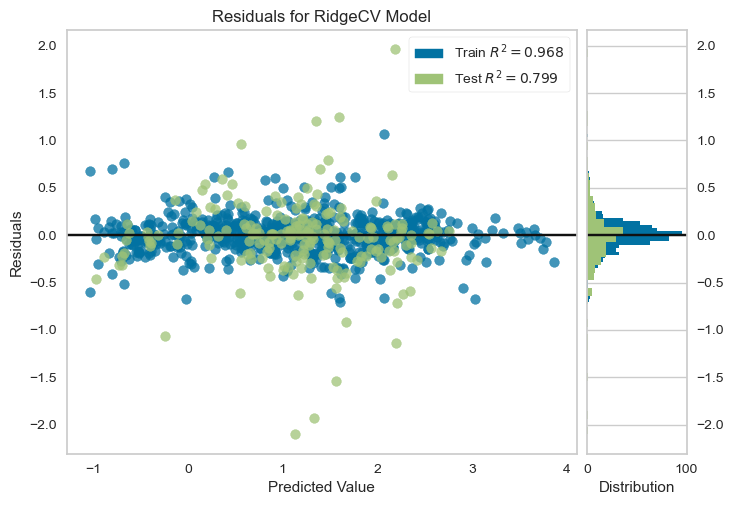

<AxesSubplot:title={'center':'Residuals for RidgeCV Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [63]:
res_visualizer = ResidualsPlot(exported_pipeline)

res_visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
res_visualizer.score(X_test, y_test)  # Evaluate the model on the test data
res_visualizer.ax.grid(False)
res_visualizer.show()  

## 6. Conclusion

In this study, different models of ML were used to predict the p*K*<sub>BHX</sub> value.
The RDKit package was used to calculate the molecular descriptors